In [1]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy
from tqdm.notebook import tqdm, trange

In [2]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
api = wandb.Api(timeout=200)

In [4]:
MT50_ENV_NAMES = [
    "assembly",
    "basketball",
    "bin-picking",
    "box-close",
    "button-press-topdown",
    "button-press-topdown-wall",
    "button-press",
    "button-press-wall",
    "coffee-button",
    "coffee-pull",
    "coffee-push",
    "dial-turn",
    "disassemble",
    "door-close",
    "door-lock",
    "door-open",
    "door-unlock",
    "hand-insert",
    "drawer-close",
    "drawer-open",
    "faucet-open",
    "faucet-close",
    "hammer",
    "handle-press-side",
    "handle-press",
    "handle-pull-side",
    "handle-pull",
    "lever-pull",
    "peg-insert-side",
    "pick-place-wall",
    "pick-out-of-hole",
    "reach",
    "push-back",
    "push",
    "pick-place",
    "plate-slide",
    "plate-slide-side",
    "plate-slide-back",
    "plate-slide-back-side",
    "peg-unplug-side",
    "soccer",
    "stick-push",
    "stick-pull",
    "push-wall",
    "reach-wall",
    "shelf-place",
    "sweep-into",
    "sweep",
    "window-open",
    "window-close",
]

In [6]:
def get_run_interp_wall_time(run, y_key, max_time):
    x_vals = np.linspace(0, max_time, 1000)
    h = pd.DataFrame(run.scan_history(keys=['_timestamp', y_key]))
    try:
        rel_time = h['_timestamp'] - h['_timestamp'][0]
        interp_y = np.interp(x_vals, rel_time, h[y_key])
        return interp_y
    except KeyError:
        print("Could not get keys in run", run)
    return None

In [7]:
runs_by_algo_seed_env = {}
max_time = 6 * 60 * 60

In [8]:
algo = "kl-proj"
group = "trust-region-layers-kl-metaworld-logged"
extra_filter = {}
runs = api.runs(
    path="resl-mixppo/stabilized-rl",
    filters={
        "$and": [
            {"group": group},
            {"$not": {"tags": "exclude-from-paper"}},
            {'summary_metrics.global_step': {"$gt": 1 }},
            extra_filter
        ]
    },
)
print(f"Got {len(runs)} runs for group {group}")

Got 349 runs for group trust-region-layers-kl-metaworld-logged


In [9]:
for run in tqdm(runs):
    key = (algo, run.config['seed'], run.config['game'][len("metaworld-"):])
    success_rate = get_run_interp_wall_time(run, 'evaluation_reward/success_rate', max_time)
    runs_by_algo_seed_env.setdefault(key, []).append(success_rate)

  0%|          | 0/349 [00:00<?, ?it/s]

In [10]:
runs_by_algo_seed_env_copy = copy.deepcopy(runs_by_algo_seed_env)

In [11]:
algo = "ppo"
group = "ppo-tianshou-metaworld"
extra_filter = {}
runs = api.runs(
    path="resl-mixppo/stabilized-rl",
    filters={
        "$and": [
            {"group": group},
            {"$not": {"tags": "exclude-from-paper"}},
            {'summary_metrics.global_step': {"$gt": 1 }},
            extra_filter
        ]
    },
)
print(f"Got {len(runs)} runs for group {group}")

Got 475 runs for group ppo-tianshou-metaworld


In [12]:
for run in tqdm(runs):
    key = (algo, run.config['seed'], run.config['env'])
    success_rate = get_run_interp_wall_time(run, 'test/success_rate', max_time)
    runs_by_algo_seed_env.setdefault(key, []).append(success_rate)

  0%|          | 0/475 [00:00<?, ?it/s]

In [13]:
runs_by_algo_seed_env_copy2 = copy.deepcopy(runs_by_algo_seed_env)

In [14]:
algo = "fixpo"
group = "xppo-tianshou-metaworld"
extra_filter = {"config.target_coeff": 3, "config.fixup_loop": 1, "config.fixup_every_repeat": 1, "config.eps_kl": 0.5}
runs = api.runs(
    path="resl-mixppo/stabilized-rl",
    filters={
        "$and": [
            {"group": group},
            {"$not": {"tags": "exclude-from-paper"}},
            {'summary_metrics.global_step': {"$gt": 1 }},
            extra_filter
        ]
    },
)
print(f"Got {len(runs)} runs for group {group}")

Got 448 runs for group xppo-tianshou-metaworld


In [15]:
for run in tqdm(runs):
    key = (algo, run.config['seed'], run.config['env'])
    success_rate = get_run_interp_wall_time(run, 'test/success_rate', max_time)
    runs_by_algo_seed_env.setdefault(key, []).append(success_rate)

  0%|          | 0/448 [00:00<?, ?it/s]

In [30]:
algos = ["fixpo", "ppo", "kl-proj"]
algo_seeds = {}
for seed in range(5):
    for algo in algos:
        run_total = sum(bool(runs_by_algo_seed_env.get((algo, seed, env))) for env in MT50_ENV_NAMES)
        print(f"seed={seed}, algo={algo} env_count={run_total}")
        if run_total == 50:
            algo_seeds.setdefault(algo, []).append(seed)

seed=0, algo=fixpo env_count=50
seed=0, algo=ppo env_count=50
seed=0, algo=kl-proj env_count=50
seed=1, algo=fixpo env_count=50
seed=1, algo=ppo env_count=50
seed=1, algo=kl-proj env_count=49
seed=2, algo=fixpo env_count=50
seed=2, algo=ppo env_count=50
seed=2, algo=kl-proj env_count=50
seed=3, algo=fixpo env_count=0
seed=3, algo=ppo env_count=0
seed=3, algo=kl-proj env_count=50
seed=4, algo=fixpo env_count=0
seed=4, algo=ppo env_count=0
seed=4, algo=kl-proj env_count=50


In [31]:
algo_seeds

{'fixpo': [0, 1, 2], 'ppo': [0, 1, 2], 'kl-proj': [0, 2, 3, 4]}

In [32]:
max_over_runs = {}
pd_dict = {'algo': [], 'Runtime (hours)': [], 'Success Rate': []}
hours = np.linspace(0, max_time / (60 * 60), 1000)
for algo in algos:
    algo_list = [algo for _ in range(1000)]
    for seed in algo_seeds[algo]:
        for env in MT50_ENV_NAMES:
            best_composite = np.max(np.stack([res for res in runs_by_algo_seed_env[(algo, seed, env)] if res is not None]), axis=0)
            max_over_runs[(algo, seed, env)] = best_composite
            pd_dict['algo'].extend(algo_list)
            pd_dict['Runtime (hours)'].extend(hours)
            pd_dict['Success Rate'].extend(best_composite)

In [33]:
data = pd.DataFrame.from_dict(pd_dict)
algo_renames = {
    "kl-proj": "KL Proj.",
    "ppo": "PPO",
    "fixpo": "FixPO",
}
data["Algorithm"] = [algo_renames[alg] for alg in data["algo"]]

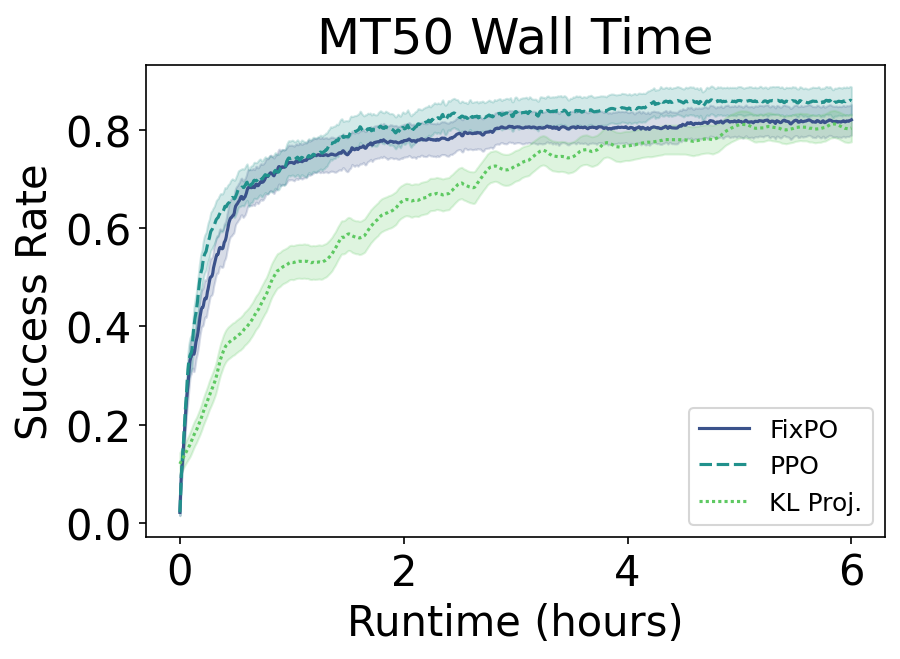

In [34]:
sns.lineplot(
    data=data,
    x="Runtime (hours)",
    y="Success Rate",
    hue="Algorithm",
    errorbar=('se', 1.0),
    style="Algorithm",
     palette="viridis",
)
plt.title("MT50 Wall Time")
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.savefig(f"mt50_450runs_6hours.pdf")

<Axes: xlabel='Runtime (hours)', ylabel='Success Rate'>

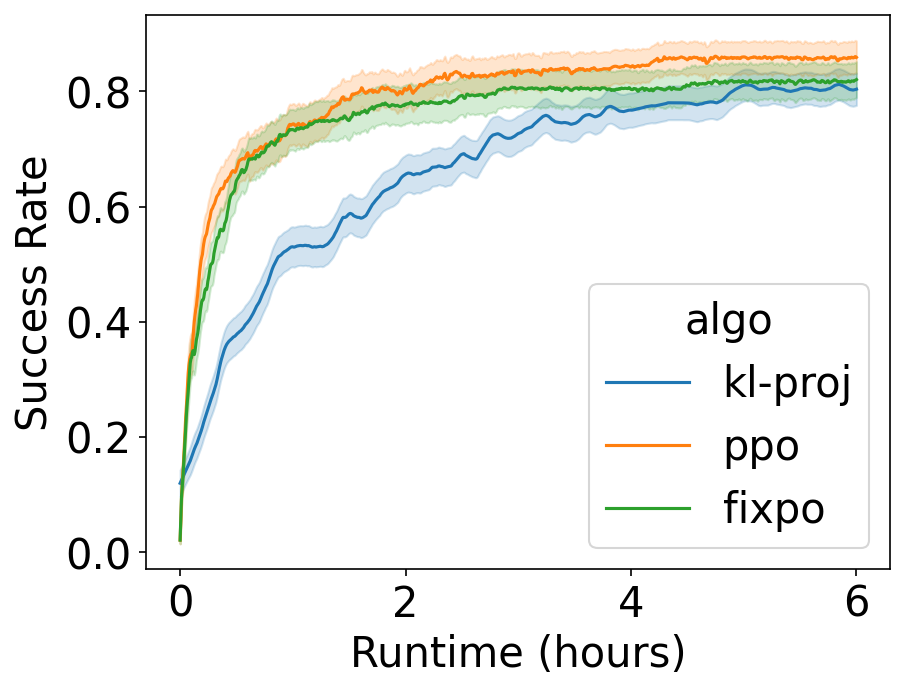

In [26]:
sns.lineplot(data=data, x="Runtime (hours)", y="Success Rate", hue='algo', 
             errorbar=('se', 1.0),)

In [107]:
data_10m = pd.DataFrame.from_dict(pd_dict)

<Axes: xlabel='Total Env Steps', ylabel='Success Rate'>

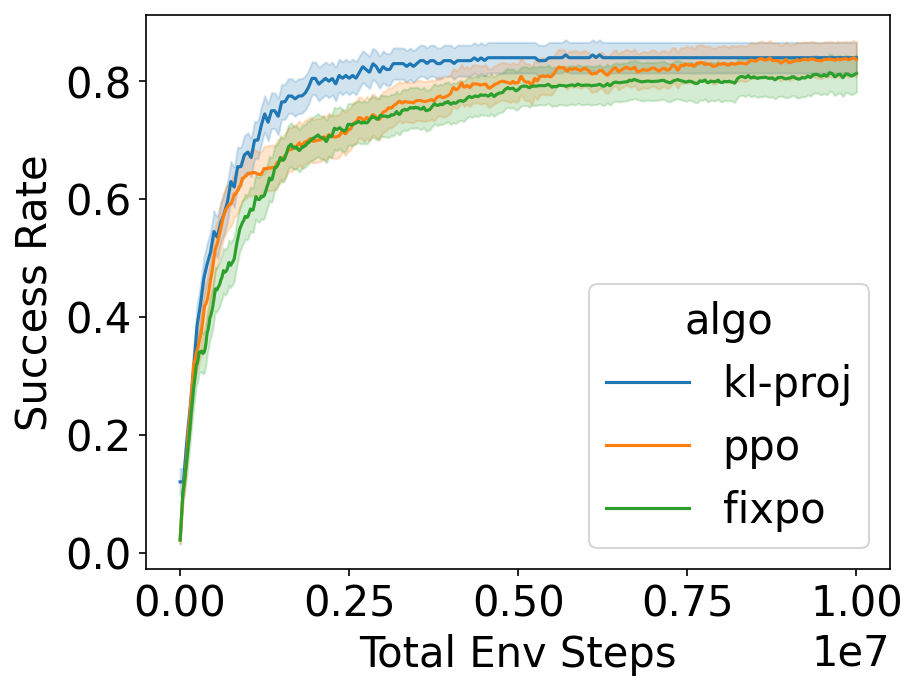

In [118]:
sns.lineplot(data=data_10m, x="Total Env Steps", y="Success Rate", hue='Algorithm', 
             errorbar=('se', 1.0),)

In [120]:
data_10m["Algorithm"] = data_10m["algo"]

In [127]:
algo_renames = {
    "kl-proj": "KL Proj.",
    "ppo": "PPO",
    "fixpo": "FixPO",
}
data_10m["Algorithm"] = [algo_renames[alg] for alg in data_10m["algo"]]
#data_10m["Total Environment Steps"] = data_10m["Total Env Steps"]

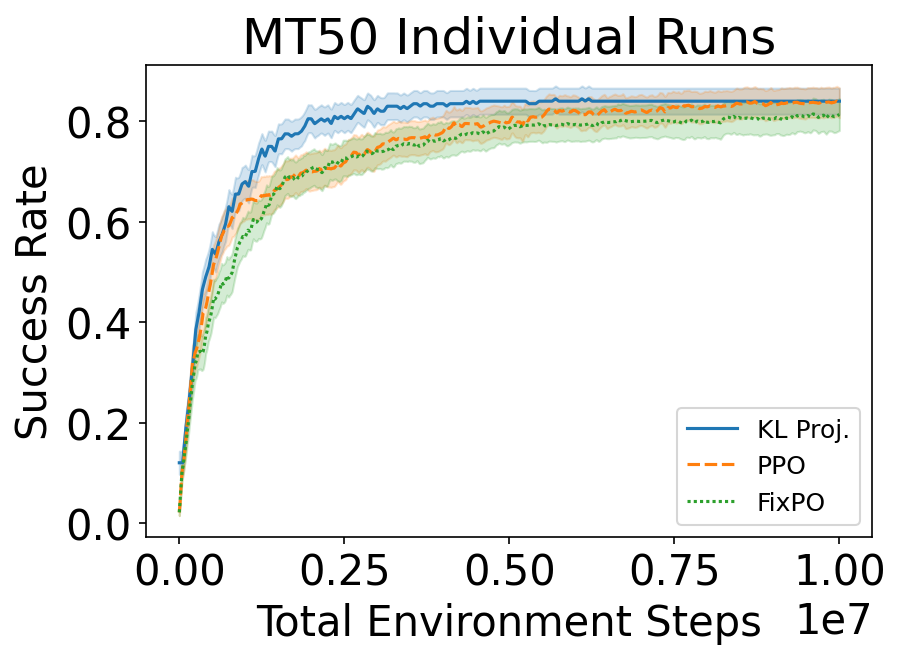

In [136]:
sns.lineplot(
    data=data_10m,
    x="Total Environment Steps",
    y="Success Rate",
    hue="Algorithm",
    errorbar=('se', 1.0),
    style="Algorithm",
#     palette="viridis",
)
plt.title("MT50 Individual Runs")
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.savefig(f"mt50_450runs_10m_steps.pdf")

In [130]:
run.summary

{'update/loss/kl': 0.07964432239532471, 'update/loss/vf': 0.2647915184497833, 'update/loss/beta': 0.220221683382988, 'test/success_rate': 0.10000000149011612, '_step': 8, '_wandb': {'runtime': 85}, 'global_step': 80000, 'update/loss': -2.6451401710510254, 'update/loss/ent': 3.631418228149414, 'update/fixup_grad_steps': 2.799999952316284, 'test/reward': 657.4105834960938, 'train/episode': 20, 'update/loss/pg': -2.7512636184692383, 'test/reward_std': 802.43359375, '_runtime': 83.28702473640442, '_timestamp': 1695624657.3212698, 'train/reward': 361.0486755371094, 'train/success_rate': 0, 'test/length_std': 0, 'test/length': 500, 'update/beta': 1.6431198120117188, 'train/length': 500, 'test/env_step': 80000}

In [140]:
res = runs[0].scan_history(keys=['_)

In [144]:
runs[0].history()['_timestamp']

0      1.695836e+09
1      1.695836e+09
2      1.695836e+09
3      1.695836e+09
4      1.695836e+09
           ...     
495    1.695875e+09
496    1.695875e+09
497    1.695875e+09
498    1.695875e+09
499    1.695875e+09
Name: _timestamp, Length: 500, dtype: float64